Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.bias', 'predictions.LayerNorm.bias', 'predictions.decoder.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.dense.weight']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/4


440/440 [==============================] - 386s 828ms/step - loss: 0.4802 - accuracy: 0.8174 - val_loss: 0.3961 - val_accuracy: 0.8484
Epoch 2/4
440/440 [==============================] - 377s 858ms/step - loss: 0.3719 - accuracy: 0.8522 - val_loss: 0.3881 - val_accuracy: 0.8535
Epoch 3/4
440/440 [==============================] - 377s 858ms/step - loss: 0.3121 - accuracy: 0.8768 - val_loss: 0.4335 - val_accuracy: 0.8429
Epoch 4/4
95/95 [==============================] - 30s 283ms/step


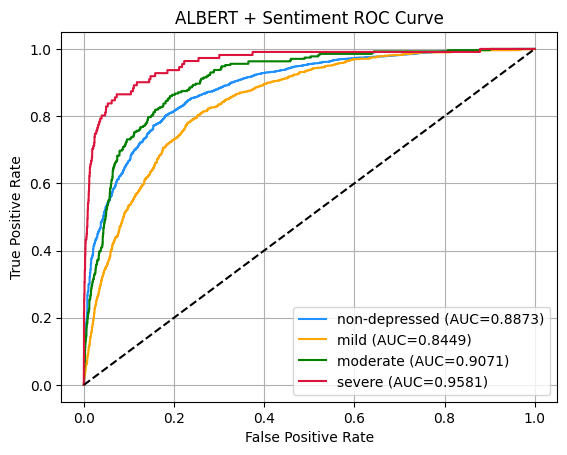

In [ ]:
# Install dependencies
!pip install -q transformers vaderSentiment scikit-learn

import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import AlbertTokenizer, TFAlbertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# Load dataset
path = '/content/SOD22_dataset.csv'
df = pd.read_csv(path)
df = df[['tweet', 'label']].dropna()

# Convert label if needed
label_map = {'non-depressed': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
if df['label'].dtype == 'object':
    df['label'] = df['label'].map(label_map)

# Sentiment analysis
analyzer = SentimentIntensityAnalyzer()
def get_sentiment_scores(text):
    scores = analyzer.polarity_scores(str(text))
    return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]

sentiment_features = np.array([get_sentiment_scores(t) for t in df['tweet']])

# Train-val-test split
train_texts, temp_texts, train_labels, temp_labels, train_sents, temp_sents = train_test_split(
    df['tweet'], df['label'], sentiment_features, test_size=0.3, stratify=df['label'], random_state=42)
val_texts, test_texts, val_labels, test_labels, val_sents, test_sents = train_test_split(
    temp_texts, temp_labels, temp_sents, test_size=0.5, stratify=temp_labels, random_state=42)

# Tokenize
tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
max_length = 64

def tokenize(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

train_encodings = tokenize(train_texts)
val_encodings = tokenize(val_texts)
test_encodings = tokenize(test_texts)

# Build dataset
num_classes = 4

def make_dataset(encodings, labels, sentiments):
    inputs = {k: v for k, v in encodings.items()}
    dataset = tf.data.Dataset.from_tensor_slices((inputs, tf.keras.utils.to_categorical(labels, num_classes), sentiments))
    return dataset.batch(64)

train_dataset = make_dataset(train_encodings, train_labels, train_sents)
val_dataset = make_dataset(val_encodings, val_labels, val_sents)
test_dataset = make_dataset(test_encodings, test_labels, test_sents)

# Custom model with ALBERT + Sentiment
class AlbertSentimentClassifier(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.albert = TFAlbertModel.from_pretrained('albert-base-v2')
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.concat_dense = tf.keras.layers.Dense(128, activation='relu')
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        albert_inputs, sentiment_inputs = inputs
        outputs = self.albert(**albert_inputs)
        cls_output = outputs.last_hidden_state[:, 0, :]  # CLS token
        x = tf.concat([cls_output, sentiment_inputs], axis=1)
        x = self.dropout(x)
        x = self.concat_dense(x)
        return self.classifier(x)

# Prepare sentiment tensors
def add_sentiment_to_batches(dataset):
   return dataset.map(lambda x, y, s: ((x, tf.cast(s, tf.float32)), y))


train_dataset = add_sentiment_to_batches(train_dataset)
val_dataset = add_sentiment_to_batches(val_dataset)
test_dataset = add_sentiment_to_batches(test_dataset)

# Compile and train
model = AlbertSentimentClassifier()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.fit(train_dataset, validation_data=val_dataset, epochs=4)

# Predict and evaluate
y_true = tf.keras.utils.to_categorical(test_labels, num_classes)
pred_logits = model.predict(test_dataset)
y_pred = pred_logits

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = roc_auc_score(y_true[:, i], y_pred[:, i])

# Plot ROC Curve
plt.figure()
colors = ['dodgerblue', 'orange', 'green', 'crimson']
labels = ['non-depressed', 'mild', 'moderate', 'severe']
for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, label=f'{labels[i]} (AUC={roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ALBERT + Sentiment ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFAlbertModel: ['predictions.bias', 'predictions.dense.bias', 'predictions.LayerNorm.weight', 'predictions.LayerNorm.bias', 'predictions.dense.weight', 'predictions.decoder.bias']
- This IS expected if you are initializing TFAlbertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFAlbertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Epoch 1/4


440/440 [==============================] - 386s 833ms/step - loss: 0.4740 - accuracy: 0.8209 - val_loss: 0.3879 - val_accuracy: 0.8479
Epoch 2/4
440/440 [==============================] - 363s 824ms/step - loss: 0.3708 - accuracy: 0.8521 - val_loss: 0.3909 - val_accuracy: 0.8516
Epoch 3/4
440/440 [==============================] - 363s 824ms/step - loss: 0.3086 - accuracy: 0.8777 - val_loss: 0.4733 - val_accuracy: 0.8522
Epoch 4/4
95/95 [==============================] - 30s 285ms/step


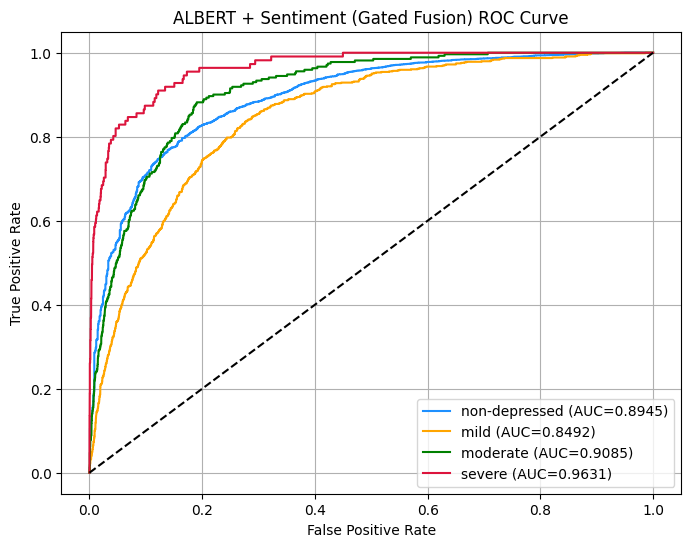

In [ ]:
# ✅ Install dependencies
!pip install -q transformers vaderSentiment scikit-learn

# ✅ Imports
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, roc_auc_score
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import AlbertTokenizer, TFAlbertModel

# ✅ Load and preprocess data
path = '/content/SOD22_dataset.csv'
df = pd.read_csv(path)
label_map = {'non-depressed': 0, 'mild': 1, 'moderate': 2, 'severe': 3}
df['label'] = df['label'].map(label_map)

def preprocess(text):
    text = str(text).lower()
    text = re.sub(r'#\w+|@\w+|http\S+|www\.\S+', '', text)
    text = re.sub(r"’", "'", text)
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'s", " is", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'t", " not", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'m", " am", text)
    text = re.sub(r"[^\w\s]", '', text)
    text = re.sub(r'\d+', '', text)
    return re.sub(r'\s+', ' ', text).strip()

df['clean_tweet'] = df['tweet'].apply(preprocess)

# ✅ Sentiment features
analyzer = SentimentIntensityIntensityAnalyzer()
def get_sentiment(text):
    scores = analyzer.polarity_scores(str(text))
    return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]

df['sentiment'] = df['tweet'].apply(get_sentiment)
sentiments = np.stack(df['sentiment'].values)

# ✅ Train-val-test split
X_train, X_temp, y_train, y_temp, s_train, s_temp = train_test_split(
    df['clean_tweet'], df['label'], sentiments, test_size=0.3, stratify=df['label'], random_state=42)
X_val, X_test, y_val, y_test, s_val, s_test = train_test_split(
    X_temp, y_temp, s_temp, test_size=0.5, stratify=y_temp, random_state=42)

# ✅ Tokenization
model_name = 'albert-base-v2'
tokenizer = AlbertTokenizer.from_pretrained(model_name)
def tokenize(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=64, return_tensors='tf')

train_enc = tokenize(X_train)
val_enc = tokenize(X_val)
test_enc = tokenize(X_test)

# ✅ Dataset creation
num_classes = 4
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes)
y_val_cat = tf.keras.utils.to_categorical(y_val, num_classes)
y_test_cat = tf.keras.utils.to_categorical(y_test, num_classes)

def make_dataset(enc, labels, sentiments):
    ds = tf.data.Dataset.from_tensor_slices(((dict(enc), tf.cast(sentiments, tf.float32)), labels))
    return ds.batch(64).prefetch(tf.data.AUTOTUNE)

train_ds = make_dataset(train_enc, y_train_cat, s_train)
val_ds = make_dataset(val_enc, y_val_cat, s_val)
test_ds = make_dataset(test_enc, y_test_cat, s_test)

# ✅ Model with gated fusion
class AlbertSentimentFusion(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.albert = TFAlbertModel.from_pretrained(model_name)
        self.sent_dense = tf.keras.layers.Dense(128, activation='relu')
        self.sent_match_dim = tf.keras.layers.Dense(self.albert.config.hidden_size, activation='relu')
        self.gate = tf.keras.layers.Dense(self.albert.config.hidden_size * 2, activation='sigmoid') # Gate input dimension should match fusion_input dimension
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.out = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        albert_inputs, sentiment = inputs
        albert_out = self.albert(**albert_inputs).last_hidden_state[:, 0, :]  # CLS token
        sent_proj = self.sent_dense(sentiment)
        sent_proj_matched = self.sent_match_dim(sent_proj)
        fusion_input = tf.concat([albert_out, sent_proj_matched], axis=-1)
        gate_val = self.gate(fusion_input)
        fused = gate_val[:, :self.albert.config.hidden_size] * albert_out + gate_val[:, self.albert.config.hidden_size:] * sent_proj_matched # Split gate_val
        fused = self.dropout(fused)
        return self.out(fused)


# ✅ Compile and train
model = AlbertSentimentFusion()
model.compile(optimizer=tf.keras.optimizers.Adam(2e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_ds, validation_data=val_ds, epochs=4)

# ✅ Evaluate
logits = model.predict(test_ds)
y_probs = logits
y_true_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# ✅ ROC Curve
fpr, tpr, aucs = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    aucs[i] = roc_auc_score(y_true_bin[:, i], y_probs[:, i])

plt.figure(figsize=(8,6))
colors = ['dodgerblue', 'orange', 'green', 'crimson']
labels = ['non-depressed', 'mild', 'moderate', 'severe']
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], label=f"{labels[i]} (AUC={aucs[i]:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ALBERT + Sentiment (Gated Fusion) ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()